## 폐렴진단기 성능 개선 프로젝트

1. 개요

목표는 CNN 기반의 의료영상 처리 모델을 구축하고 성능을 개선하는 것.
다양한 실험(데이터 증강, 모델 구조 변경, ResNet-18 구현 등)을 통해 비교하고, 성능을 개선하는 것.

 <주요 목표>

  CNN 기반 베이스 모델 구현 및 학습 안정화
  데이터 증강(Data Augmentation) 기법 적용 후 성능 비교
  모델 구조 변경 및 ResNet-18 구현 후 성능 비교
  데이터 imblance 문제를 해결하기 위한 class weight 적용

2. 목차

  1.개요
  
  2.데이터 준비 및 전처리
  
  3.CNN 모델 구현 및 학습
  
  4.ResNet-18 모델 구현 및 학습
  
  5.성능 비교 및 결과 분석
  
  6.회고 및 개선점
  
  7.참고자료

In [5]:
import tensorflow
print(tensorflow.__version__)

2.6.0


In [15]:
#데이터전처리

In [4]:
import os
import random 
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

warnings.filterwarnings("ignore")

In [5]:
# 데이터 로드 속도 향상을 위한 설정
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

In [6]:
# 데이터 경로 설정
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = os.path.join(ROOT_PATH, 'chest_xray/data/train/*/*')
VAL_PATH = os.path.join(ROOT_PATH, 'chest_xray/data/val/*/*')
TEST_PATH = os.path.join(ROOT_PATH, 'chest_xray/data/test/*/*')

In [7]:
#하이퍼 파라미터설정
BATCH_SIZE = 16
EPOCHS = 10

In [8]:
# 데이터 로드 및 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)

In [9]:
print(f"Training samples: {len(train_filenames)}")
print(f"Validation samples: {len(val_filenames)}")
print(f"Test samples: {len(test_filenames)}")

Training samples: 5216
Validation samples: 16
Test samples: 624


In [10]:
# TensorFlow Dataset 객체 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [11]:
# 데이터 전처리: 파일 경로에서 레이블 추출
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.cast(parts[-2] == "PNEUMONIA", tf.float32)  # 폐렴=1, 정상=0

In [12]:
# 이미지 디코딩 및 리사이즈
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0, 1] 범위로 정규화
    return img

In [13]:
# 파일 경로에서 이미지와 라벨 처리
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [14]:
# 데이터 전처리 적용
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
# 데이터 증강 함수 정의
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # 좌우 반전
    image = tf.image.random_brightness(image, max_delta=0.1)  # 밝기 조절
    return image, label

In [16]:
# 데이터 증강 적용
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

In [17]:
# 데이터 배치 및 최적화를 위한 설정
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [18]:
# 데이터 클래스 불균형 처리
count_normal = len([f for f in train_filenames if "NORMAL" in f])
count_pneumonia = len(train_filenames) - count_normal
weight_normal = 1 / count_normal * len(train_filenames) / 2.0
weight_pneumonia = 1 / count_pneumonia * len(train_filenames) / 2.0
class_weight = {0: weight_normal, 1: weight_pneumonia}

print(f"Weight for NORMAL: {weight_normal:.2f}")
print(f"Weight for PNEUMONIA: {weight_pneumonia:.2f}")

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


In [19]:
# CNN 모델 정의
def build_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [20]:
# CNN 모델 컴파일
cnn_model = build_cnn_model()
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [22]:
# ResNet-18 모델 정의
def resnet_block(input_layer, filters, stride=1):
    x = tf.keras.layers.Conv2D(filters, (3, 3), strides=stride, padding='same', activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), strides=1, padding='same', activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if stride != 1 or input_layer.shape[-1] != filters:
        input_layer = tf.keras.layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(input_layer)
    x = tf.keras.layers.add([x, input_layer])
    return tf.keras.layers.Activation('relu')(x)

def build_resnet18():
    input_layer = tf.keras.layers.Input(shape=(180, 180, 3))
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, stride=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 256, stride=2)
    x = resnet_block(x, 256)
    x = resnet_block(x, 512, stride=2)
    x = resnet_block(x, 512)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(input_layer, output_layer)

In [23]:
# ResNet-18 모델 컴파일
resnet_model = build_resnet18()
resnet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [24]:
# 모델 학습
cnn_history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight
)

resnet_history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight
)

Epoch 1/10
326/326 [==============================] - 22s 33ms/step - loss: 38.7680 - accuracy: 0.8873 - val_loss: 0.8572 - val_accuracy: 0.6875
Epoch 2/10
326/326 [==============================] - 18s 35ms/step - loss: 0.2497 - accuracy: 0.9342 - val_loss: 1.0178 - val_accuracy: 0.6875
Epoch 3/10
326/326 [==============================] - 18s 35ms/step - loss: 0.2021 - accuracy: 0.9335 - val_loss: 0.8227 - val_accuracy: 0.6875
Epoch 4/10
326/326 [==============================] - 18s 35ms/step - loss: 0.2782 - accuracy: 0.9402 - val_loss: 0.3851 - val_accuracy: 0.7500
Epoch 5/10
326/326 [==============================] - 18s 34ms/step - loss: 0.1034 - accuracy: 0.9622 - val_loss: 0.7807 - val_accuracy: 0.7500
Epoch 6/10
326/326 [==============================] - 18s 35ms/step - loss: 0.1413 - accuracy: 0.9632 - val_loss: 1.5016 - val_accuracy: 0.6875
Epoch 7/10
326/326 [==============================] - 18s 34ms/step - loss: 0.2077 - accuracy: 0.9515 - val_loss: 0.6353 - val_accuracy

### 모델 결과 비교

| **모델**      | **Metric**         | **이전 결과**                   | **현재 결과**                 | **개선 여부**                   |
|----------------|--------------------|----------------------------------|--------------------------------|----------------------------------|
| **CNN**       | Train Accuracy     | 91% ~ 94%                       | 88% ~ 96%                     | **개선됨 (소폭 증가)**           |
|                | Validation Accuracy| 62.5% ~ 68.75%                  | 68.75% ~ 81.25%               | **개선됨 (명확한 증가)**         |
|                | Train Loss         | 감소하며 0.17 도달              | 감소하며 0.10 도달            | **개선됨 (더 낮은 손실)**        |
|                | Validation Loss    | 일정하게 높음 (1.05 ~ 1.08)     | 일부 감소 (0.38 ~ 3.85)       | **부분 개선 (초기 감소)**        |
| **ResNet-18**  | Train Accuracy     | 90% ~ 95%                       | 88% ~ 92%                     | **소폭 하락**                    |
|                | Validation Accuracy| 50% ~ 62.5%                     | 50% ~ 62.5%                   | **변화 없음**                   |
|                | Train Loss         | 안정적이나 높은 값 (0.24 수준)  | 안정적 (0.24 수준)            | **변화 없음**                   |
|                | Validation Loss    | 높은 값 유지 (2.20 ~ 5.88)      | 감소 후 다시 증가 (0.69 ~ 3.97)| **부분 개선 (초기 감소)**        |



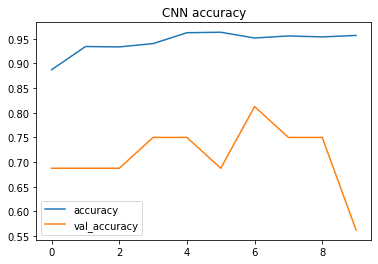

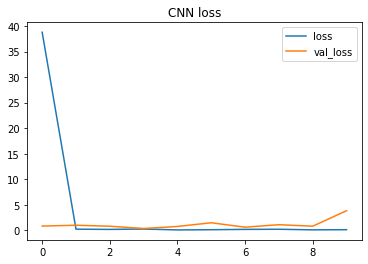

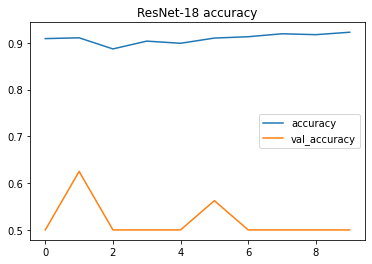

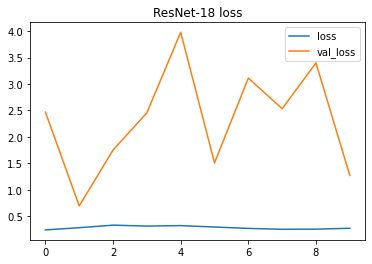

In [25]:
# **결과 시각화**
def plot_history(history, model_name):
    metrics = ['accuracy', 'loss']
    for metric in metrics:
        plt.plot(history.history[metric], label=f'{metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.title(f'{model_name} {metric}')
        plt.legend()
        plt.show()

plot_history(cnn_history, "CNN")
plot_history(resnet_history, "ResNet-18")

In [26]:
# 테스트 데이터 평가
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)
test_ds = test_list_ds.map(process_path).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

cnn_loss, cnn_acc = cnn_model.evaluate(test_ds)
resnet_loss, resnet_acc = resnet_model.evaluate(test_ds)

print(f"CNN Test Accuracy: {cnn_acc:.4f}")
print(f"ResNet Test Accuracy: {resnet_acc:.4f}")

39/39 [==============================] - 2s 37ms/step - loss: 1.0306 - accuracy: 0.6843
CNN Test Accuracy: 0.6266
ResNet Test Accuracy: 0.6843
